# Training BiLSTM on SNLI using ADAM

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/DL_project/
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1rxvBmpHEy23c0WZ6V3NFhmsmCCJ4quW5/DL_project
/content/drive/.shortcut-targets-by-id/1rxvBmpHEy23c0WZ6V3NFhmsmCCJ4quW5/DL_project


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import *
import os
import time
import gc
import shutil
import h5py

from dfw.dfw import DFW
from dfw.dfw.losses import set_smoothing_enabled
from dfw.dfw.losses import MultiClassHingeLoss
from dfw.experiments.InferSent.data import get_nli, get_batch, build_vocab
from dfw.experiments.InferSent.models import NLINet

from snli_train_utils import *

In [ ]:
GLOVE_PATH = "dfw/experiments/InferSent/dataset/GloVe/glove.840B.300d.txt"
nlipath = 'dfw/experiments/InferSent/dataset/SNLI'
train, valid, test = get_nli(nlipath)
word_vec = build_vocab(train['s1'] + train['s2'] +
                       valid['s1'] + valid['s2'] +
                       test['s1'] + test['s2'], GLOVE_PATH)

for split in ['s1', 's2']:
    for data_type in ['train', 'valid', 'test']:
        eval(data_type)[split] = np.array([['<s>'] +
            [word for word in sent.split() if word in word_vec] +
            ['</s>'] for sent in eval(data_type)[split]])


** TRAIN DATA : Found 549367 pairs of train sentences.
** DEV DATA : Found 9842 pairs of dev sentences.
** TEST DATA : Found 9824 pairs of test sentences.
Found 38957(/43479) words with glove vectors
Vocab size : 38957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word_emb_dim = 300
config_nli_model = {
    'n_words'        :  len(word_vec)         ,
    'word_emb_dim'   :  word_emb_dim   ,
    'enc_lstm_dim'   :  2048   ,
    'n_enc_layers'   :  1   ,
    'dpout_model'    :  0.    ,
    'dpout_fc'       :  0.       ,
    'fc_dim'         :  512         ,
    'bsize'          :  64     ,
    'n_classes'      :  3      ,
    'pool_type'      :  'max'      ,
    'nonlinear_fc'   :  0   ,
    'encoder_type'   :  'BLSTMEncoder'   ,
    'use_cuda'       :  True                  ,

}

In [ ]:
trainer = Net_Trainer(device, 'nli_adam_snli', config_nli_model, word_vec, train, valid, test, lr=1e-4, optm='adam', loss='svm', batch_size=64, epochs=100, 
                          lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

cuda Tesla T4
Epoch:0   Loss:0.136   Val loss:1.37   Accuracy:46.078   Best val loss:1.37   Time taken:335.065
Epoch:1   Loss:0.071   Val loss:1.079   Accuracy:50.438   Best val loss:1.079   Time taken:336.949
Epoch:2   Loss:0.061   Val loss:1.075   Accuracy:55.531   Best val loss:1.075   Time taken:343.199
Epoch:3   Loss:0.059   Val loss:1.05   Accuracy:60.031   Best val loss:1.05   Time taken:334.443
Epoch:4   Loss:0.05   Val loss:1.02   Accuracy:59.5   Best val loss:1.02   Time taken:334.954
Epoch:5   Loss:0.052   Val loss:0.955   Accuracy:59.859   Best val loss:0.955   Time taken:336.21
Epoch:6   Loss:0.059   Val loss:1.111   Accuracy:56.156   Best val loss:0.955   Time taken:337.421
Epoch:7   Loss:0.055   Val loss:0.911   Accuracy:59.844   Best val loss:0.911   Time taken:342.586
Epoch:8   Loss:0.052   Val loss:1.002   Accuracy:56.781   Best val loss:0.911   Time taken:342.11
Epoch:9   Loss:0.057   Val loss:1.186   Accuracy:50.016   Best val loss:0.911   Time taken:340.661


cuda Tesla T4
Epoch:10   Loss:0.058   Val loss:0.84   Accuracy:66.422   Best val loss:0.84   Time taken:330.26
Epoch:11   Loss:0.05   Val loss:0.811   Accuracy:65.891   Best val loss:0.811   Time taken:327.447
Epoch:12   Loss:0.047   Val loss:0.947   Accuracy:62.062   Best val loss:0.811   Time taken:329.669
Epoch:13   Loss:0.051   Val loss:0.864   Accuracy:65.062   Best val loss:0.811   Time taken:328.246
Epoch:14   Loss:0.059   Val loss:0.913   Accuracy:63.938   Best val loss:0.811   Time taken:332.778
Epoch:15   Loss:0.054   Val loss:0.912   Accuracy:60.188   Best val loss:0.811   Time taken:330.77
Epoch:16   Loss:0.049   Val loss:0.985   Accuracy:62.5   Best val loss:0.811   Time taken:331.698
Epoch:17   Loss:0.056   Val loss:0.758   Accuracy:68.031   Best val loss:0.758   Time taken:336.511
Epoch:18   Loss:0.048   Val loss:1.017   Accuracy:59.531   Best val loss:0.758   Time taken:332.229
Epoch:19   Loss:0.057   Val loss:0.801   Accuracy:67.797   Best val loss:0.758   Time taken:3

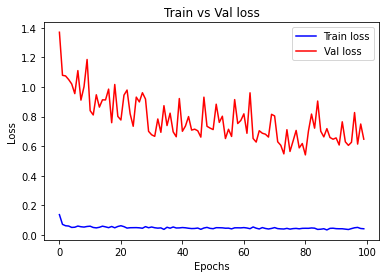

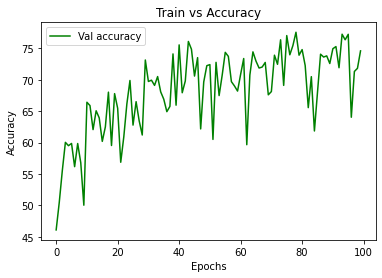

Best epoch: 80
Test accuracy: 67.5 %


In [ ]:
# Conitnue training by loading checkpoint
# Best epoch = epoch with least val loss
trainer = Net_Trainer(device, 'nli_adam_snli', config_nli_model, word_vec, train, valid, test, load_ckpt='v1_ckpt_nli_adam_snli', lr=1e-4, optm='adam', loss='svm', 
                      batch_size=64, epochs=100, lr_decay=0.99, lr_shrink=5.0, weight_decay=0, mom=0, smooth=False)
best_epoch, losses, errors, accs, testacc = trainer.train()
plot_train(losses, errors, accs)
print('Best epoch:',best_epoch)
print('Test accuracy:',testacc,'%')

In [ ]:
best_acc = test_model(device, config_nli_model, 'v1_ckpt_nli_adam_snli_best', test, 64, word_vec)
print('Test accuracy of best model:',best_acc)

Test accuracy of best model: 66.765625


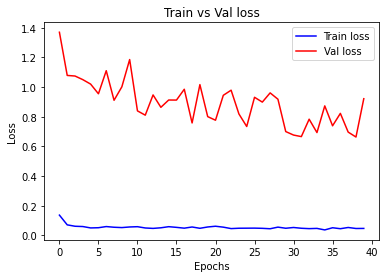

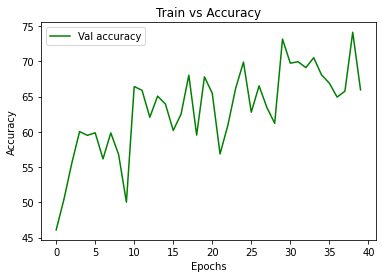

In [ ]:
checkpoint = torch.load('checkpoints/v1_ckpt_nli_adam_snli_best', map_location=torch.device('cpu'))
losses = checkpoint['loss_hist'][:40]
errors = checkpoint['err_hist'][:40]
accs = checkpoint['acc_hist'][:40]
plot_train(losses, errors, accs)